In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
import plotly.graph_objs as go
import plotly.express as px
from sklearn.metrics import r2_score

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
from pmdarima.arima import ADFTest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import xgboost as xgb

In [2]:
def moving_average(series, n):
    series = np.array(series)
    res: list[int] = []
    S: int = 0
    for i in range(n):
        S += series[i]
    res.append(S / n)
    for i in range(n, len(series)):
        S = S + series[i] - series[i - n]
        res.append(S / n)
    return res

def exponential_average(series, n):
    alpha = 2 / (n+1)
    series = np.array(series)
    pred: list[int] = [series[0]]
    for i in range(1, len(series)):
        pred.append(alpha * series[i] + (1 - alpha) * pred[i-1])
    return np.array(pred)

In [3]:
def intersection_search(ser1, ser2):
    ser1, ser2 = np.array(ser1), np.array(ser2)
    intersect_ = np.zeros(len(ser1))
    r1_ = np.array([ser1[1:] > ser2[1:]])
    r2_ = np.array([ser1[:-1] > ser2[:-1]])
    intersect_ = r1_ != r2_
    res = []
    for i in range(len(intersect_[0])):
        if intersect_[0][i] == True:
            res.append(i)
    return res

In [4]:
def data_prepare(df):
    df['date'] = [x[:-6] for x in df['date'].to_list()]
    df['date'] = pd.to_datetime(df['date'], format = "%Y-%m-%d %H:%M:%S")
    df = df.set_index(pd.DatetimeIndex(df['date']))
    
    df = df.drop(['date', 'otc'], axis = 1)
    df_H = df.resample('H').agg({'open': 'first', 'high' : 'max', 'low' : 'min', 'close' : 'last', 'volume': 'sum'}).dropna()
    return df_H

In [17]:
name_stock = 'AAPL'
df2017 = pd.read_csv('data/2017/' + name_stock + '.csv')
df2018 = pd.read_csv('data/2018/' + name_stock + '.csv')
df2019 = pd.read_csv('data/2019/' + name_stock + '.csv')
df2020 = pd.read_csv('data/2021/' + name_stock + '.csv')

In [18]:
data_train = data_prepare(pd.concat([df2017, df2018, df2019]))
data_test = data_prepare(df2020)

In [19]:
feature_size = 50
predict_size = 50

In [20]:
def prepare_data(df):
    global feature_size
    global predict_size
    
    ma_50 = moving_average(df['close'], 50)
    ma_100 = moving_average(df['close'], 100)
    intersect_ = [x + 100 for x in intersection_search(ma_50[50:], ma_100)]
    
    X_ = []
    Y_ = []
    for el in intersect_:
        feature1 = np.array( np.diff(df['close'][el - feature_size: el]) )
        feature2 = np.array( df['volume'][el - feature_size: el] )
        X_.append( np.concatenate([feature1, feature2]) )
        Y_.append( df['close'][el + predict_size] - df['close'][el])
    X_ = np.array(X_)
    Y_ = np.array(Y_)
    return X_, Y_, intersect_

In [21]:
X_train, Y_train, intersect_train = prepare_data(data_train)
X_test, Y_test, intetsect_test = prepare_data(data_test)
Y_train = (np.sign(Y_train) + 1) // 2
Y_test = (np.sign(Y_test) + 1) // 2

Обучаем модельку

In [22]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dtest = xgb.DMatrix(X_test, label=Y_test)

In [23]:
param = {'max_depth': 3, 'eta': 0.3, 'num_class': 3}
num_round = 20

In [24]:
bst = xgb.train(param, dtrain, num_round)
Y_pred = bst.predict(dtest)

In [25]:
from sklearn.metrics import accuracy_score
print( accuracy_score(Y_test, Y_pred) )

0.75


Функция отрисовывания:

In [26]:
def drow_res(df, intersect, overlap=None):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(df.shape[0])), y=df['close']))
    level = [int(df['close'].min()), int(df['close'].max())]
    for i in range(len(intersect)):
        el = intersect[i]
        if overlap is not None:
            if overlap[i] == 1:
                color_line = 'green'
            else:
                color_line = 'red'
        else:
            coloe_line = color_line = 'black'
        fig.add_trace(go.Scatter(x=[el, el], y=level, mode="lines", line=go.scatter.Line(color=color_line), showlegend=False))
        
    fig.update_layout(height=500, width=1000)
    fig.show()
    

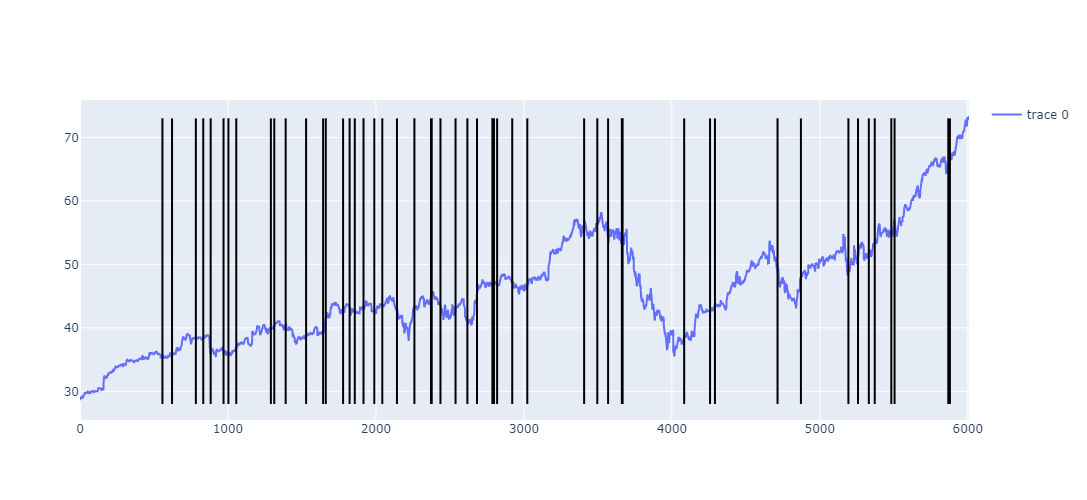

In [27]:
drow_res(data_train, intersect_train)

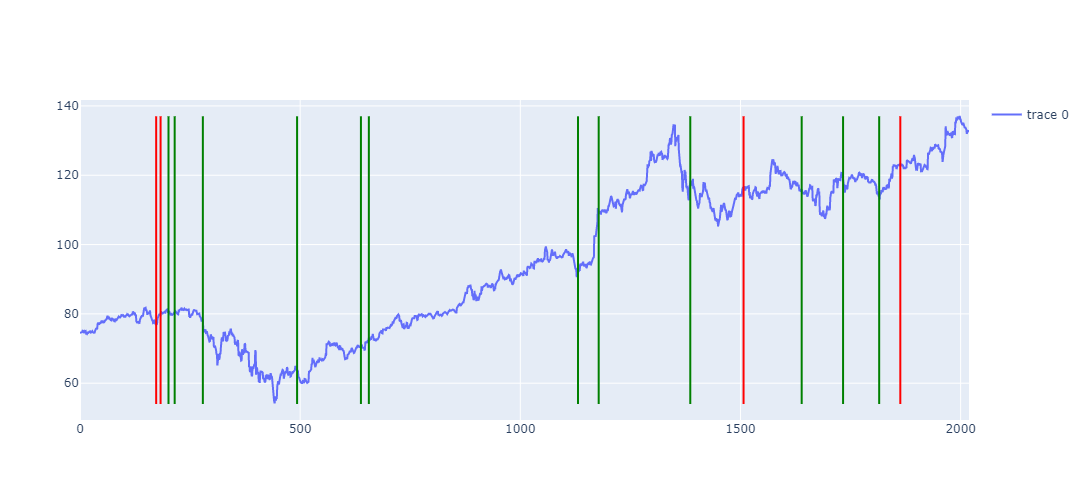

In [28]:
overlap = Y_pred == Y_test
drow_res(data_test, intetsect_test, overlap)